## Fractal Pre-training

#### Shuang Gao
#### Jackson School of Geoscience, UT Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

In image recognition/classification tasks, sufficient training images with correct labels are hard to obtain, or may contain mistakes due to human subjective mis-labeling. To address this problem, fractal images are generated via iterative funtion system (IFS), which parameters are automatically as the category definition. 
The images with corresponding group labels are pre-trained by a neural-network and then the model can be used to be fine-tuned with a real image dataset (natural image or seismic image). We learned that fractal images can be used as basic components to do image recognition. It is suggested to apply 3D~5D fractals with IFS to detect patterns on seismic data.
The basic idea and most codes are derived from a paper (Kataoka etc). I did various optimzation on the codes to improve its performance dramatically, and tried to explore the applicability on seismic data.

In [20]:
import os                          # set working directory, run executables
import random                      # to get a random number 
import numpy as np                 # arrays and matrix math
from PIL import Image              # generate images to and from ndarray
import matplotlib.pyplot as plt    # plotting utils
import matplotlib.image as img     # read and write images

import torch                                 # pytorch ver1.10, tensor computation and deep NN with strong GPU acceleration
import torch.nn as nn                        # pytorch provides basic building blocks for graphs, and loss function like cross entropy
import torch.optim as optim                  # provide optimization algorithms, like SGD
import torchvision.transforms as transforms  # integrate data preprocessing steps, like normalize
import torchvision.datasets as datasets      # set dataset folder and link with transform
import torchvision.models as models          # provides predefined NN model, like ResNet

from torchviz import make_dot, make_dot_from_trace

##### The function below generates a directory and is shared by sub worksteps 

In [8]:
def make_directory(path, name):
    ''' This function creates a directory if it doesnot exist. Then return the directory.  '''
    thedir = os.path.join(path, name)
    if not os.path.exists(thedir):
        os.mkdir(thedir)
    return thedir       

### Load Data
In the spirit of the project, all pre-training data is generated. The data storage folder is specified.
##### This section defines all parameters for the workflow

In [9]:
numof_category=100      # number of fractal categories 
fillrate=  0.2          # ratio of (fractal pixels) / (all pixels in the image). Indicate how occupied an image of points
minFillrate = 0.01      # the minimum filling ratio of an instance of a fractal category
imagesize=256           # image size of generated fractal images
imagesize2 = imagesize*imagesize   # image area
pad_x = 6               # x padding on scaled image, the min margin of each fractal pattern to the image edge
pad_y = 6               # y padding on scaled image, the min margin of each fractal pattern to the image edge

nstep=100000            # number of random walk steps in each fractal category generation.

save_dir = './data'     # The folder where all data generated and stored
img_dir = make_directory(save_dir, 'rate' + str(fillrate) + '_category' + str(numof_category))   # folder of fractal category png images
print(img_dir)
cat_dir = make_directory(save_dir, 'csv_rate' + str(fillrate) + '_category' + str(numof_category)) # folder of fractal category vector text files
print(cat_dir)

## settings for fractal database 
FractalDB = 'FractalDB_rate' + str(fillrate)+'_category'+str(numof_category)
FractalDB_dir = make_directory(save_dir, FractalDB)    # folder of all fractal category instances, the fractal database
print(FractalDB_dir)

weight=0.4       # the deformation applied to the 6 
num_iteration = 50000   # 

weight_csv = os.path.join('weights', 'weights_'+str(weight)+'.csv')   # './weights/weights_0.1.csv'
numof_instance = 10  # instance, 10 => 1000 instance, 100 => 10,000 instance per category    

## settings for pretraining
path2traindb = FractalDB_dir 
path2weight = 'weights'

num_epochs=50  
lr = 0.1  # initial learning ranum_te
weight_decay= 1e-4
momentum = 0.9
start_epoch = 1
batch_size = 128  #256
crop_size =  224

no_cuda = True
gpu_id = -1
num_workers = 12  # os.cpu_count()=16
save_interval = 10 # the frequency of saving the resulted weight to a file
log_interval =  100
seed = 1

device = torch.device("cuda")  # if no GPU, use "cpu" instead of "cuda" GPU

./data\rate0.2_category100
./data\csv_rate0.2_category100
./data\FractalDB_rate0.2_category100


### Fractal Pretraining workflow

Below is the definition of Iterative Function System (IFS). It will be used in Category search step and fractal database creation.

In [4]:
# the code below is modified from https://github.com/hirokatsukataoka16/FractalDB-Pretrained-ResNet-PyTorch/blob/main/param_search/ifs_simple.py
# a lot of changes to add functionality to run fractal database generation
class ifs_Fractal():

    def __init__(self,function, select_prob):
        '''Initialize the IFS with its composing vectors and probability '''
        # IFS function, the set of vectors for the category
        self.function  = function
        # Iterative results
        self.xs,self.ys = [0.0],[0.0]
        # Select probability
        self.select_prob = select_prob
        
    def giveDim(self):
        ''' give debugging info'''
        #print(str(self.function.shape))
        #print(str(len(self.select_prob)))
        #print("minx: %d" % np.max(self.xs))
        print(len(self.xs))
    
    def calculate(self,iteration):
        ''' calculate number of iteration steps for an image pattern. Give the x,y series.
        with each step is a random selection of the vectors that define the fractal category'''
        rand = np.random.random(iteration)
        prev_x,prev_y = self.xs[0], self.ys[0]
        
        for i in range(iteration-1):  
            for j in range(len(self.select_prob)):
                if rand[i] <= self.select_prob[j]:
                    # ax+cy+e  //not ax+by+e!
                    next_x = prev_x * self.function[j][0] + prev_y * self.function[j][2] + self.function[j][4]   
                    # bx+dy+f //cx+dy+f
                    next_y = prev_x * self.function[j][1] + prev_y * self.function[j][3] + self.function[j][5]   
                    self.xs.append(next_x)
                    self.ys.append(next_y)
                    prev_x = next_x
                    prev_y = next_y
                    break    
    def __rescale(self,size_x,size_y,pad_x,pad_y):
        # Scale adjustment
        xs = np.array(self.xs)
        ys = np.array(self.ys)
        if np.any(np.isnan(xs)):
            
            nan_index = np.where(np.isnan(xs))            
            # remove 100 values preceding the nans
            extend = np.array(range(nan_index[0][0]-100,nan_index[0][0]))
            
            delete_row = np.append(extend,nan_index)
            
            delete_row = nan_index
            xs = np.delete(xs,delete_row,axis=0)
            ys = np.delete(ys,delete_row,axis=0)
            print ("early_stop on x: %d" % len(xs))
        if np.any(np.isnan(ys)):            
            nan_index = np.where(np.isnan(ys))            
            extend = np.array(range(nan_index[0][0]-100,nan_index[0][0]))            
            delete_row = np.append(extend,nan_index)
            delete_row = nan_index
            xs = np.delete(xs,delete_row,axis=0)
            ys = np.delete(ys,delete_row,axis=0)
            print ("early_stop on y: %d" % len(ys))
        
        xmax,xmin,ymax,ymin = np.max(xs),np.min(xs),np.max(ys),np.min(ys)
        
        self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))
        self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))
        
    # only generate np image np array
    def draw_point(self,size_x,size_y,pad_x,pad_y):
        self.__rescale(size_x,size_y,pad_x,pad_y)       
        
        npimage = np.array(Image.new("RGB", (size_x, size_y)))
        
        for i in range(len(self.xs)):   # very inefficient
            npimage[self.ys[i],self.xs[i],:] =127,127,127
        return npimage
    
    # directly generate images and save to path
    def draw_patch(self,size_x,size_y,pad_x,pad_y):
        self.__rescale(size_x,size_y,pad_x,pad_y)
        image = Image.new("RGB", (size_x, size_y))        

        for i in range(len(self.xs)):
            mask_pattern = '{:09b}'.format(random.randrange(1,512))           
            patch = self.make_patch3_3(mask_pattern,[127,127,127])
            image.paste(patch, (self.xs[i]+1, self.ys[i]+1))
        patch.close()
        return image
        
        
    def make_patch3_3(self,mask,patch_color):
        patch_color = np.array(patch_color)
        patch = np.zeros((3,3,3),np.uint8)
        for i in range(0,3):
            for j in range(0,3):
                for k in range(0,3):
                    patch[i,j,k] = patch_color[k]*int(mask[i*3+j])   # orig is wrong: patch[i,j,:] = patch_color*int(mask[i*3+j])
        return Image.fromarray(patch)

### Workstep 1. Category search

In [9]:
class_num = 0

while(class_num < numof_category): #numof_category
    # the fractal let is a combination of #param_size of affine transform vectors 
    param_size = np.random.randint(2,6)    # (2,8)
    #print(param_size)
    params = np.random.uniform(-1.0,1.0,(param_size,6))
    sum_det = 0.0
    #print(params)
    intprob = np.zeros((param_size,1), dtype=float)    
    for i in range(param_size):
        a,b,c,d = params[i,0:4]
        det = abs(a*d-b*c)
        sum_det += det
        intprob[i] = sum_det
    # the probability of each affine transform is det_i/sum(det_i)
    intprob /= sum_det   
    
    generators = ifs_Fractal(function=params,select_prob=intprob)
    generators.calculate(nstep)
    #generators.giveDim()
    img = generators.draw_point(imagesize, imagesize, pad_x, pad_y) #image (x,y pad x,y)
    #generators.giveDim()
    rfill = np.count_nonzero(img[:,:,0]) / float(imagesize2)
    
    if rfill >= fillrate:
        class_str =  '%05d' % class_num
        print ('save: '+class_str)       
        Image.fromarray(img).save(os.path.join(img_dir, class_str + '.png')) 
        csvParams = np.concatenate((params,intprob), axis=1)
        #print(csvParams)
        np.savetxt(os.path.join(cat_dir, class_str + '.csv'), csvParams, delimiter=',')
        class_num += 1
        #print(param_size)
        #print(intprob)
        print ('pixels: %f' % rfill)        
        
    else:
        pass

save: 00000
pixels: 0.233246
save: 00001
pixels: 0.206314


<ipython-input-8-891b58bde391>:29: RuntimeWarning: overflow encountered in double_scalars
  next_y = prev_x * self.function[j][1] + prev_y * self.function[j][3] + self.function[j][5]
<ipython-input-8-891b58bde391>:27: RuntimeWarning: invalid value encountered in double_scalars
  next_x = prev_x * self.function[j][0] + prev_y * self.function[j][2] + self.function[j][4]


early_stop on x: 24928


<ipython-input-8-891b58bde391>:70: RuntimeWarning: invalid value encountered in subtract
  self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))
<ipython-input-8-891b58bde391>:70: RuntimeWarning: invalid value encountered in true_divide
  self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))
<ipython-input-8-891b58bde391>:71: RuntimeWarning: invalid value encountered in subtract
  self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))
<ipython-input-8-891b58bde391>:71: RuntimeWarning: invalid value encountered in true_divide
  self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))


save: 00002
pixels: 0.474380


<ipython-input-8-891b58bde391>:29: RuntimeWarning: invalid value encountered in double_scalars
  next_y = prev_x * self.function[j][1] + prev_y * self.function[j][3] + self.function[j][5]


early_stop on x: 5771
save: 00003
pixels: 0.229370
save: 00004
pixels: 0.300964
early_stop on x: 29456
early_stop on y: 29455


<ipython-input-8-891b58bde391>:70: RuntimeWarning: overflow encountered in subtract
  self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))


save: 00005
pixels: 0.210938
save: 00006
pixels: 0.232330
save: 00007
pixels: 0.367691
save: 00008
pixels: 0.217300
early_stop on x: 12762
save: 00009
pixels: 0.261108
early_stop on x: 4958
save: 00010
pixels: 0.235138


<ipython-input-8-891b58bde391>:27: RuntimeWarning: overflow encountered in double_scalars
  next_x = prev_x * self.function[j][0] + prev_y * self.function[j][2] + self.function[j][4]


early_stop on x: 5670
early_stop on y: 5669
save: 00011
pixels: 0.369202
early_stop on x: 13336
early_stop on y: 13335
early_stop on x: 2356
save: 00012
pixels: 0.330368
save: 00013
pixels: 0.276749
save: 00014
pixels: 0.204407
early_stop on x: 33992
early_stop on y: 33991
early_stop on x: 4654
early_stop on y: 4653
early_stop on x: 7117
save: 00015
pixels: 0.325424
early_stop on x: 5593


<ipython-input-8-891b58bde391>:71: RuntimeWarning: overflow encountered in subtract
  self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))


save: 00016
pixels: 0.248245
save: 00017
pixels: 0.476517
early_stop on x: 6514
early_stop on y: 6513
early_stop on x: 6476
early_stop on y: 6475
early_stop on x: 7899
early_stop on x: 8812
save: 00018
pixels: 0.419556
save: 00019
pixels: 0.305298
save: 00020
pixels: 0.239929
save: 00021
pixels: 0.398895
early_stop on x: 5507
early_stop on y: 5506
save: 00022
pixels: 0.302597
early_stop on x: 9229
save: 00023
pixels: 0.228775
save: 00024
pixels: 0.250320
save: 00025
pixels: 0.222916
save: 00026
pixels: 0.217056
save: 00027
pixels: 0.307922
save: 00028
pixels: 0.238800
save: 00029
pixels: 0.214081
save: 00030
pixels: 0.432999
save: 00031
pixels: 0.288589
early_stop on x: 11613
save: 00032
pixels: 0.382217
early_stop on x: 11679
early_stop on y: 11678
early_stop on x: 6184
early_stop on x: 5714
early_stop on y: 5713
early_stop on x: 2788
early_stop on x: 9173
save: 00033
pixels: 0.281296
save: 00034
pixels: 0.375671
save: 00035
pixels: 0.251846
save: 00036
pixels: 0.247192
save: 00037
pi

Pick some interesting images to show. Each is a category representative

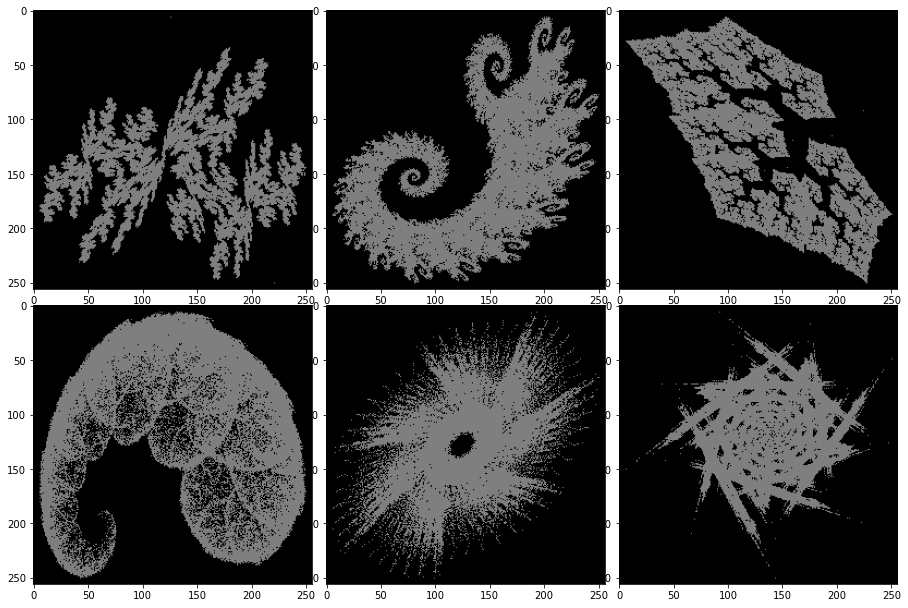

In [17]:
plt.subplot(231)
im = img.imread(os.path.join(img_dir, '00002.png'))
plt.imshow(im)

plt.subplot(232)
im = img.imread(os.path.join(img_dir, '00025.png'))
plt.imshow(im)

plt.subplot(233)
im = img.imread(os.path.join(img_dir, '00044.png'))
plt.imshow(im)

plt.subplot(234)
im = img.imread(os.path.join(img_dir, '00070.png'))
plt.imshow(im)

plt.subplot(235)
im = img.imread(os.path.join(img_dir, '00085.png'))
plt.imshow(im)

plt.subplot(236)
im = img.imread(os.path.join(img_dir, '00092.png'))
plt.imshow(im)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2, wspace=0.05, hspace=0.05)
plt.show()

### Workstep 2. Create FractalDB

In [5]:
csv_names = os.listdir(cat_dir)
# cat_dir:  ./data\csv_rate0.2_category10
csv_names.sort()

weights = np.genfromtxt(weight_csv,dtype=str,delimiter=',')

# The code below is modified from 
# https://github.com/hirokatsukataoka16/FractalDB-Pretrained-ResNet-PyTorch/blob/main/fractal_renderer/make_fractaldb.py
# I fixed the bugs that generate almost empty images, which has accuracy of 80%, but my version has accuracy of 98%

for csv_name in csv_names:   # for each category
    catname, ext = os.path.splitext(csv_name)
    
    if ext != '.csv': # Skip except for csv file
        continue
    
    print (csv_name)
    params0 = np.genfromtxt(os.path.join(cat_dir, csv_name), dtype=str,delimiter=',')
    # FractalDB_dir: './data\\FractalDB_rate0.2_category10'
    # DBCatdir:  './data\\FractalDB_rate0.2_category10/0000'
    DBCatdir = make_directory(FractalDB_dir, catname) # Make directory
    
    iweight = 0
    for weight in weights:  # for each weight (change one number in the vector)
        
        strWeight= 'iWeight%02d' % iweight 
        print((strWeight))        
        params = np.zeros((params0.shape[0],6),dtype=float)
        intprob = np.zeros((params0.shape[0],1),dtype=float)
        
        for i in range(params.shape[0]):            
            params[i,:] = (params0[i,:6]).astype(float) * (weight).astype(float)            
            intprob[i] = float(params0[i,6])
        
        for count in range(numof_instance):
            strCount = 'iCount'+str(count)          
           # print(strCount)
            generators = ifs_Fractal(function=params,select_prob=intprob)
            generators.calculate(num_iteration)            
            
            image = generators.draw_patch(imagesize, imagesize, pad_x, pad_y)
            rfill = np.count_nonzero(np.array(image)[:,:,0]) / float(imagesize2)
            iGetRfill = 0
            # Too small fill rate can render almost zero point in an instance image
            # Therefore minFillrates constraint =0.01 is set. It is selected from visual observation on the generated intra category images, 
            # to see if they can be a representative patterns. 
            while rfill < minFillrate:
                generators = ifs_Fractal(function=params,select_prob=intprob)
                generators.calculate(num_iteration)            
                
                image = generators.draw_patch(imagesize, imagesize, pad_x, pad_y)
                rfill = np.count_nonzero(np.array(image)[:,:,0]) / float(imagesize2)   
                iGetRfill +=1
                if iGetRfill>20:
                    iGetRfill = -1
                    # if after many steps rfill is still too small, it means the weight group won't work
                    print('cant get rfill = %f' % minFillrate)
                    break
            if iGetRfill < 0:
                break
            
            image.save(os.path.join(DBCatdir,                                 
                                catname + "_" + strWeight + "_" + strCount + "_flip0"  + ".png"))
            
            # Coordinate transformation            
            
            image1 = image.transpose(Image.FLIP_TOP_BOTTOM)
            image1.save(os.path.join(DBCatdir,                                 
                                catname + "_" + strWeight + "_" + strCount + "_flip1"  + ".png"))
            
            image1 = image1.transpose(Image.FLIP_LEFT_RIGHT)
            image1.save(os.path.join(DBCatdir,                                 
                                catname + "_" + strWeight + "_" + strCount + "_flip2"  + ".png"))
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            image.save(os.path.join(DBCatdir,                                 
                                catname + "_" + strWeight + "_" + strCount + "_flip3"  + ".png"))
            
            image.close()
            image1.close()
            
        iweight +=1        
    

00000.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00001.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00002.csv
iWeight00
cant get rfill = 0.010000
iWeight01
iWeight02
iWeight03
iWeight04


<ipython-input-4-6b0d717720ab>:27: RuntimeWarning: overflow encountered in double_scalars
  next_x = prev_x * self.function[j][0] + prev_y * self.function[j][2] + self.function[j][4]
<ipython-input-4-6b0d717720ab>:27: RuntimeWarning: invalid value encountered in double_scalars
  next_x = prev_x * self.function[j][0] + prev_y * self.function[j][2] + self.function[j][4]


early_stop on x: 3678


<ipython-input-4-6b0d717720ab>:70: RuntimeWarning: invalid value encountered in subtract
  self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))
<ipython-input-4-6b0d717720ab>:70: RuntimeWarning: invalid value encountered in true_divide
  self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))
<ipython-input-4-6b0d717720ab>:71: RuntimeWarning: invalid value encountered in subtract
  self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))
<ipython-input-4-6b0d717720ab>:71: RuntimeWarning: invalid value encountered in true_divide
  self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))


early_stop on x: 3813
early_stop on x: 3649
early_stop on x: 3478
early_stop on x: 3610
early_stop on x: 4022
early_stop on x: 3604
early_stop on x: 3573
early_stop on x: 3541
early_stop on x: 3696
early_stop on x: 3673
early_stop on x: 3828
early_stop on x: 3623
early_stop on x: 3615
early_stop on x: 3532
early_stop on x: 3618
early_stop on x: 3795
early_stop on x: 3540
early_stop on x: 3714
early_stop on x: 3680
early_stop on x: 3632
early_stop on x: 3694
cant get rfill = 0.010000
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00003.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00004.csv
iWeight00
iWeight01
iWeight02
iWeight03
iW

<ipython-input-4-6b0d717720ab>:29: RuntimeWarning: overflow encountered in double_scalars
  next_y = prev_x * self.function[j][1] + prev_y * self.function[j][3] + self.function[j][5]


early_stop on x: 5363


<ipython-input-4-6b0d717720ab>:29: RuntimeWarning: invalid value encountered in double_scalars
  next_y = prev_x * self.function[j][1] + prev_y * self.function[j][3] + self.function[j][5]


early_stop on x: 5148
early_stop on y: 5147
early_stop on x: 5306
early_stop on y: 5305
early_stop on x: 5559
early_stop on y: 5558


<ipython-input-4-6b0d717720ab>:70: RuntimeWarning: overflow encountered in subtract
  self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))


early_stop on x: 5294
early_stop on y: 5293


<ipython-input-4-6b0d717720ab>:71: RuntimeWarning: overflow encountered in subtract
  self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))


early_stop on x: 5445
early_stop on x: 5065
early_stop on x: 5222
early_stop on y: 5221
early_stop on x: 4839
early_stop on x: 5649
early_stop on y: 5648
early_stop on x: 5107
early_stop on y: 5106
early_stop on x: 5490
early_stop on y: 5489
early_stop on x: 5245
early_stop on x: 5506
early_stop on y: 5505
early_stop on x: 5257
early_stop on x: 5030
early_stop on y: 5029
early_stop on x: 5839
early_stop on y: 5838
early_stop on x: 4840
early_stop on x: 4948
early_stop on x: 5231
early_stop on y: 5230
early_stop on x: 5324
early_stop on x: 4920
early_stop on y: 4919
cant get rfill = 0.010000
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00005.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00006.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
ea

early_stop on x: 15065
early_stop on x: 15863
early_stop on x: 17112
early_stop on y: 17111
early_stop on x: 16467
early_stop on y: 16466
early_stop on x: 16091
early_stop on x: 15497
early_stop on x: 16160
early_stop on x: 15952
early_stop on x: 16082
early_stop on x: 15084
early_stop on x: 17398
early_stop on x: 17108
early_stop on x: 15801
early_stop on x: 16442
early_stop on y: 16441
cant get rfill = 0.010000
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
early_stop on x: 14633
early_stop on y: 14632
early_stop on x: 16071
early_stop on x: 15460
early_stop on y: 15459
early_stop on x: 13685
early_stop on x: 15345
early_stop on y: 15344
early_stop on x: 14634
early_stop on x: 15774
early_stop on x: 15807
early_stop on y: 15806
early_stop on x: 16238
early_stop on x: 16479
early_stop on x: 14670
early_stop on y: 14669
early_stop on x: 14550
early_stop on x: 14866
early_stop on y: 14865
early_stop on x: 14857
ear

early_stop on x: 5814
early_stop on y: 5813
early_stop on x: 5567
early_stop on x: 5747
early_stop on x: 5867
early_stop on x: 5797
early_stop on y: 5796
early_stop on x: 5982
early_stop on y: 5981
early_stop on x: 6072
early_stop on y: 6071
early_stop on x: 5803
early_stop on x: 6085
early_stop on x: 6136
early_stop on y: 6135
early_stop on x: 5967
early_stop on x: 5790
early_stop on y: 5789
early_stop on x: 5789
early_stop on y: 5788
early_stop on x: 6261
early_stop on x: 5628
early_stop on y: 5627
cant get rfill = 0.010000
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
early_stop on x: 22085
early_stop on x: 20626
early_stop on x: 22011
early_stop on x: 21653
early_stop on x: 19324
early_stop on x: 19174
early_stop on y: 19173
early_stop on x: 20964
early_stop on y: 20963
early_stop on x: 19769
early_stop on x: 20617
early_stop on y: 20616
early_stop on x: 20740
early_stop on x: 20369
early_stop on x: 21986
ear

<ipython-input-4-6b0d717720ab>:70: RuntimeWarning: overflow encountered in double_scalars
  self.xs = np.uint16((xs-xmin) / (xmax-xmin) * float(size_x-2*pad_x)+float(pad_x))


early_stop on x: 25917
early_stop on x: 21192
early_stop on y: 21191
early_stop on x: 22518
early_stop on y: 22517
early_stop on x: 25481
early_stop on y: 25480
early_stop on x: 23925
early_stop on x: 25214
early_stop on x: 23578
early_stop on y: 23577
early_stop on x: 22427
early_stop on y: 22426
early_stop on x: 23978
early_stop on y: 23977
early_stop on x: 23794
early_stop on y: 23793
early_stop on x: 20483
early_stop on y: 20482
early_stop on x: 23205
early_stop on x: 21855
early_stop on y: 21854
early_stop on x: 22726
early_stop on y: 22725
cant get rfill = 0.010000
iWeight09
iWeight10
iWeight11
iWeight12
early_stop on x: 23175
early_stop on x: 25714
early_stop on y: 25713
early_stop on x: 25055
early_stop on x: 19993
early_stop on y: 19992
early_stop on x: 24448
early_stop on x: 24834
early_stop on x: 23488
early_stop on y: 23487
early_stop on x: 23984
early_stop on y: 23983
early_stop on x: 26870
early_stop on y: 26869
early_stop on x: 22965
early_stop on y: 22964
early_stop on 

iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00034.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00035.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
early_stop on x: 5246
early_stop on x: 6182
early_stop on y: 6181
early_stop on x: 5048
early_stop on x: 5025
early_stop on x: 5019
early_stop on x: 5870
early_stop on x: 5272
early_stop on y: 5271
early_stop on x: 5612
early_stop on y: 5611
early_stop on x: 5867
early_stop on y: 5866
early_stop on x: 5473
early_stop on x: 5544
early_stop on y: 5543
early_stop on x: 5068
early_stop on x: 4851
early_stop on x: 5348
early_stop on y: 5347
early_stop on x: 5838
early_stop on x: 5191
early_stop on y: 5190
early_stop on x: 5418
early_stop on x: 5356


early_stop on x: 29244
early_stop on y: 29243
early_stop on x: 32223
early_stop on y: 32222
early_stop on x: 28137
early_stop on x: 34335
early_stop on x: 33258
early_stop on x: 26189
early_stop on x: 26796
early_stop on x: 35079
early_stop on x: 31306
early_stop on y: 31305
early_stop on x: 32285
early_stop on x: 28696
early_stop on y: 28695
early_stop on x: 39841
early_stop on y: 39840
early_stop on x: 28110
early_stop on x: 29846
cant get rfill = 0.010000
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
early_stop on x: 3708
early_stop on x: 3604
early_stop on y: 3603
early_stop on x: 3831
early_stop on y: 3830
early_stop on x: 3748
early_stop on y: 3747
early_stop on x: 3492
early_stop on y: 3491
early_stop on x: 3763
early_stop on y: 3762
early_stop on x: 3508
early_stop on y: 3507
early_stop on x: 3624
early_stop on y: 3623
early_stop on x: 4053
early_stop on y: 4052
early_stop on x: 3603
early_stop on x: 4021

<ipython-input-4-6b0d717720ab>:71: RuntimeWarning: overflow encountered in double_scalars
  self.ys = np.uint16((ys-ymin) / (ymax-ymin) * float(size_y-2*pad_y)+float(pad_y))


early_stop on x: 3372
early_stop on y: 3371
early_stop on x: 3352
cant get rfill = 0.010000
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00048.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00049.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
early_stop on x: 3738
early_stop on x: 3642
early_stop on x: 3677
early_stop on x: 3688
early_stop on x: 3599
early_stop on x: 3663
early_stop on x: 3664
early_stop on x: 3658
early_stop on x: 3632
early_stop on x: 3750
early_stop on x: 3736
early_stop on x: 3804
early_stop on x: 3790
early_stop on x: 3657
early_stop on x: 3756
early_stop on x: 3727
early_stop on x: 3628
early_stop on 

iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00058.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00059.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00060.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
early_stop on x: 48861
early_stop on x: 38001
early_stop on x: 33713
early_stop on x: 35020
early_stop on y: 35019
early_stop on x: 45025
early_stop on x: 42969
early_sto

early_stop on x: 3571
early_stop on x: 3577
early_stop on x: 3546
early_stop on x: 3725
early_stop on x: 3596
early_stop on x: 3648
early_stop on x: 3633
early_stop on x: 3584
early_stop on y: 3583
early_stop on x: 3678
early_stop on y: 3677
early_stop on x: 3656
early_stop on x: 3645
early_stop on y: 3644
cant get rfill = 0.010000
iWeight17
iWeight18
iWeight19
iWeight20
iWeight21
iWeight22
iWeight23
iWeight24
00072.csv
iWeight00
iWeight01
iWeight02
iWeight03
iWeight04
iWeight05
iWeight06
iWeight07
iWeight08
iWeight09
iWeight10
iWeight11
iWeight12
iWeight13
iWeight14
iWeight15
iWeight16
early_stop on x: 3009
early_stop on x: 2920
early_stop on x: 3324
early_stop on x: 3046
early_stop on x: 3452
early_stop on y: 3451
early_stop on x: 3068
early_stop on x: 3312
early_stop on x: 3078
early_stop on x: 3068
early_stop on x: 3110
early_stop on x: 2811
early_stop on x: 3159
early_stop on y: 3158
early_stop on x: 3213
early_stop on x: 2947
early_stop on x: 3135
early_stop on y: 3134
early_stop

early_stop on x: 15122
early_stop on y: 15121
early_stop on x: 18638
early_stop on x: 16803
early_stop on x: 17820
early_stop on x: 16137
early_stop on y: 16136
early_stop on x: 16698
early_stop on y: 16697
early_stop on x: 17122
early_stop on y: 17121
early_stop on x: 18489
early_stop on x: 19201
early_stop on y: 19200
early_stop on x: 16604
early_stop on y: 16603
early_stop on x: 15654
early_stop on x: 17108
early_stop on x: 16240
early_stop on y: 16239
early_stop on x: 15806
early_stop on x: 16599
early_stop on x: 15490
early_stop on y: 15489
early_stop on x: 19163
early_stop on x: 18009
early_stop on y: 18008
early_stop on x: 18193
early_stop on y: 18192
early_stop on x: 16784
early_stop on y: 16783
cant get rfill = 0.010000
iWeight16
early_stop on x: 2459
early_stop on x: 2404
early_stop on y: 2403
early_stop on x: 2520
early_stop on x: 2441
early_stop on x: 2463
early_stop on x: 2453
early_stop on y: 2452
early_stop on x: 2444
early_stop on y: 2443
early_stop on x: 2537
early_sto

early_stop on x: 4289
early_stop on y: 4288
early_stop on x: 4780
early_stop on y: 4779
early_stop on x: 4444
early_stop on y: 4443
early_stop on x: 4287
early_stop on y: 4286
early_stop on x: 4545
early_stop on y: 4544
cant get rfill = 0.010000
iWeight09
iWeight10
iWeight11
early_stop on x: 10435
early_stop on x: 10073
early_stop on x: 10460
early_stop on x: 10003
early_stop on y: 10002
early_stop on x: 10732
early_stop on y: 10731
early_stop on x: 10370
early_stop on x: 10193
early_stop on x: 9930
early_stop on x: 10055
early_stop on y: 10054
early_stop on x: 9999
early_stop on x: 10415
early_stop on y: 10414
early_stop on x: 9876
early_stop on x: 10875
early_stop on x: 11134
early_stop on y: 11133
early_stop on x: 10148
early_stop on y: 10147
early_stop on x: 10976
early_stop on x: 10242
early_stop on y: 10241
early_stop on x: 10321
early_stop on x: 10638
early_stop on x: 10624
early_stop on x: 9991
early_stop on x: 10759
cant get rfill = 0.010000
iWeight12
early_stop on x: 4848
ear

early_stop on x: 13740
early_stop on y: 13739
early_stop on x: 12831
early_stop on y: 12830
early_stop on x: 13829
early_stop on y: 13828
early_stop on x: 13689
early_stop on y: 13688
early_stop on x: 13934
early_stop on y: 13933
early_stop on x: 12347
early_stop on y: 12346
early_stop on x: 13522
early_stop on y: 13521
early_stop on x: 11945
early_stop on y: 11944
early_stop on x: 13136
early_stop on y: 13135
early_stop on x: 13856
early_stop on y: 13855
early_stop on x: 13580
early_stop on y: 13579
early_stop on x: 12955
early_stop on y: 12954
early_stop on x: 13750
early_stop on y: 13749
cant get rfill = 0.010000
iWeight08
early_stop on x: 3792
early_stop on y: 3791
early_stop on x: 3926
early_stop on y: 3925
early_stop on x: 3986
early_stop on y: 3985
early_stop on x: 4173
early_stop on y: 4172
early_stop on x: 3926
early_stop on y: 3925
early_stop on x: 4179
early_stop on y: 4178
early_stop on x: 3939
early_stop on y: 3938
early_stop on x: 3968
early_stop on y: 3967
early_stop on 

early_stop on x: 4363
early_stop on x: 4186
early_stop on x: 4318
early_stop on x: 4073
early_stop on x: 4197
early_stop on y: 4196
early_stop on x: 4283
early_stop on y: 4282
early_stop on x: 4146
early_stop on y: 4145
early_stop on x: 4286
early_stop on x: 4133
early_stop on x: 4177
early_stop on x: 4154
early_stop on y: 4153
early_stop on x: 4204
early_stop on y: 4203
early_stop on x: 4167
early_stop on x: 4290
early_stop on x: 4294
early_stop on y: 4293
early_stop on x: 4289
early_stop on x: 4251
early_stop on x: 4117
cant get rfill = 0.010000
iWeight16
early_stop on x: 1683
early_stop on y: 1682
early_stop on x: 1638
early_stop on x: 1664
early_stop on y: 1663
early_stop on x: 1645
early_stop on y: 1644
early_stop on x: 1664
early_stop on x: 1671
early_stop on y: 1670
early_stop on x: 1667
early_stop on x: 1661
early_stop on x: 1669
early_stop on x: 1650
early_stop on y: 1649
early_stop on x: 1665
early_stop on x: 1672
early_stop on y: 1671
early_stop on x: 1695
early_stop on y: 1

### Workstep 3. FractalDB Pre-training

Define functions used in fractal database pretraining

In [21]:
# The code below is modified from https://github.com/hirokatsukataoka16/FractalDB-Pretrained-ResNet-PyTorch/blob/main/pretraining/train_val.py
def worker_init_fn(worker_id):
    ''' Used by DataLoader, initialize each worker with a random seed '''
    random.seed(worker_id)
    
def accuracy(output, target):
    ''' Accuracy, compare the prediction results vs defined categories '''
    with torch.no_grad():
        batch_size = target.size(0)
        _, pred = output.topk(1, 1, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)).float()
        res = correct.mul_(100.0/batch_size).sum()
        return res
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Define the training process for GPU

In [22]:
# The code below is modified from https://github.com/hirokatsukataoka16/FractalDB-Pretrained-ResNet-PyTorch/blob/main/pretraining/train_val.py
def train( model, device, train_loader, optimizer, criterion, epoch,losslist, acculist,epochlist):
        
    losses = AverageMeter()
    topacc = AverageMeter()
    
    # switch to train mode
    model.train()    
   
    for i, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)

        # data.size(): torch.Size([128, 3, 224, 224])
        # type(data) :  <class 'torch.Tensor'>
        # type(target): <class 'torch.Tensor'>
        
        # compute output
        output = model(data)
        
        # measure accuracy and record loss
        loss = criterion(output, target)
        losses.update(loss.item(), data.size(0))
        #type(loss)  ~~ <class 'torch.Tensor'>
        #type(losses.avg))) ~~ float
        acc = accuracy(output, target)   
        topacc.update(acc, data.size(0))

        #type(acc)  ~~ <class 'torch.Tensor'>
        #type(topacc.avg)  ~~ class 'torch.Tensor'>
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
       
        if i % log_interval == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc {acc.val:.3f} ({acc.avg:.3f})\t'.format(
                   epoch, i, len(train_loader), 
                    loss=losses, acc=topacc))
            
            acculist.append(topacc.avg)
            losslist.append(losses.avg)
            epochlist.append(epoch+i/len(train_loader))
        
    #return np.mean(np.array())

Pretraining step using pytorch ResNet 

In [6]:
random.seed(seed)
torch.manual_seed(seed)
# normalize the images to be mean at 0.2 because fillrate is 0.2
train_transform = transforms.Compose([transforms.RandomCrop((crop_size,crop_size)),
                                    transforms.ToTensor(),  transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.5, 0.5, 0.5])])

train_dataset = datasets.ImageFolder(path2traindb, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                         num_workers=num_workers, pin_memory=True, drop_last=True, worker_init_fn=worker_init_fn)

# Model & optimizer
usenet=models.resnet50
model = models.resnet50(pretrained=False, num_classes=numof_category).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)

#iteration = (start_epoch-1)*len(train_loader)
losslist = []
acculist = []
epochlist = []

for epoch in range(start_epoch, num_epochs + 1):
    print('start'+str(epoch))
    train( model, device, train_loader, optimizer, criterion, epoch, losslist, acculist,epochlist)
    print(epoch)
    scheduler.step()
    #iteration += len(train_loader)
    
    if epoch % save_interval == 0:
        model_state = model.cpu().state_dict()
        
        saved_weight = "{}/{}_{}_epoch{}.pth.tar".format(path2weight, FractalDB, usenet, epoch)
        torch.save(model_state, saved_weight.replace('.tar',''))
        checkpoint = "{}/{}_{}_checkpoint.pth.tar".format(path2weight, FractalDB, usenet)
        torch.save({'epoch': epoch + 1,
                    'state_dict': model_state,
                    'optimizer' : optimizer.state_dict(),
                    'scheduler' : scheduler.state_dict(),}, checkpoint)
        model = model.to(device)
torch.save(model_state, saved_weight.replace('.tar',''))


start1
Epoch: [1][0/781]	Loss 4.8376 (4.8376)	Acc 0.000 (0.000)	
Epoch: [1][100/781]	Loss 4.6094 (7.0247)	Acc 0.781 (1.006)	
Epoch: [1][200/781]	Loss 4.6087 (5.8230)	Acc 0.781 (0.976)	
Epoch: [1][300/781]	Loss 4.6142 (5.4193)	Acc 2.344 (0.947)	
Epoch: [1][400/781]	Loss 4.6022 (5.2167)	Acc 0.781 (0.960)	
Epoch: [1][500/781]	Loss 4.5712 (5.0935)	Acc 2.344 (1.107)	
Epoch: [1][600/781]	Loss 4.4821 (5.0046)	Acc 0.781 (1.245)	
Epoch: [1][700/781]	Loss 4.3967 (4.9274)	Acc 0.781 (1.396)	
1
start2
Epoch: [2][0/781]	Loss 4.4178 (4.4178)	Acc 0.781 (0.781)	
Epoch: [2][100/781]	Loss 4.3134 (4.3145)	Acc 0.000 (3.450)	
Epoch: [2][200/781]	Loss 4.1661 (4.2875)	Acc 5.469 (3.677)	
Epoch: [2][300/781]	Loss 4.2085 (4.2596)	Acc 3.906 (3.904)	
Epoch: [2][400/781]	Loss 4.1757 (4.2352)	Acc 6.250 (4.177)	
Epoch: [2][500/781]	Loss 4.0188 (4.1999)	Acc 7.031 (4.723)	
Epoch: [2][600/781]	Loss 3.9132 (4.1544)	Acc 5.469 (5.271)	
Epoch: [2][700/781]	Loss 3.9464 (4.1091)	Acc 6.250 (5.950)	
2
start3
Epoch: [3][0/781]	L

Epoch: [17][200/781]	Loss 0.2183 (0.2017)	Acc 94.531 (94.628)	
Epoch: [17][300/781]	Loss 0.2199 (0.2003)	Acc 93.750 (94.679)	
Epoch: [17][400/781]	Loss 0.1467 (0.1998)	Acc 95.312 (94.668)	
Epoch: [17][500/781]	Loss 0.2107 (0.2015)	Acc 94.531 (94.633)	
Epoch: [17][600/781]	Loss 0.0957 (0.1989)	Acc 98.438 (94.735)	
Epoch: [17][700/781]	Loss 0.1667 (0.2009)	Acc 95.312 (94.659)	
17
start18
Epoch: [18][0/781]	Loss 0.1074 (0.1074)	Acc 97.656 (97.656)	
Epoch: [18][100/781]	Loss 0.1052 (0.1679)	Acc 97.656 (95.506)	
Epoch: [18][200/781]	Loss 0.2668 (0.1768)	Acc 95.312 (95.355)	
Epoch: [18][300/781]	Loss 0.2188 (0.1828)	Acc 94.531 (95.149)	
Epoch: [18][400/781]	Loss 0.1533 (0.1855)	Acc 96.094 (95.094)	
Epoch: [18][500/781]	Loss 0.1742 (0.1904)	Acc 96.094 (94.991)	
Epoch: [18][600/781]	Loss 0.2639 (0.1941)	Acc 94.531 (94.893)	
Epoch: [18][700/781]	Loss 0.1456 (0.1962)	Acc 96.094 (94.825)	
18
start19
Epoch: [19][0/781]	Loss 0.1872 (0.1872)	Acc 94.531 (94.531)	
Epoch: [19][100/781]	Loss 0.1840 (0.1

Epoch: [33][200/781]	Loss 0.1547 (0.0939)	Acc 96.094 (97.711)	
Epoch: [33][300/781]	Loss 0.1498 (0.0928)	Acc 96.875 (97.726)	
Epoch: [33][400/781]	Loss 0.0561 (0.0900)	Acc 98.438 (97.810)	
Epoch: [33][500/781]	Loss 0.0620 (0.0888)	Acc 98.438 (97.837)	
Epoch: [33][600/781]	Loss 0.0789 (0.0874)	Acc 98.438 (97.867)	
Epoch: [33][700/781]	Loss 0.0243 (0.0883)	Acc 99.219 (97.854)	
33
start34
Epoch: [34][0/781]	Loss 0.0196 (0.0196)	Acc 100.000 (100.000)	
Epoch: [34][100/781]	Loss 0.1378 (0.0849)	Acc 96.875 (97.912)	
Epoch: [34][200/781]	Loss 0.0337 (0.0827)	Acc 99.219 (97.967)	
Epoch: [34][300/781]	Loss 0.1213 (0.0870)	Acc 96.875 (97.869)	
Epoch: [34][400/781]	Loss 0.1335 (0.0876)	Acc 96.875 (97.869)	
Epoch: [34][500/781]	Loss 0.0651 (0.0884)	Acc 98.438 (97.846)	
Epoch: [34][600/781]	Loss 0.1778 (0.0875)	Acc 95.312 (97.868)	
Epoch: [34][700/781]	Loss 0.0045 (0.0872)	Acc 100.000 (97.881)	
34
start35
Epoch: [35][0/781]	Loss 0.1150 (0.1150)	Acc 96.875 (96.875)	
Epoch: [35][100/781]	Loss 0.1509 (

KeyboardInterrupt: 

###### Plot the  accuracy and loss development per epoch. I run many times and this last time can't finish before deadline. With pretty high accuracy already, I will temporarily stop here and give the results.

In [ ]:
# since all epoch, losss and accuracy are tensor list, first change them to nparray
epochlist = np.array(epochlist)
losslist = np.array(losslist)
# acculist is a tensor list of data value and GPU memory, it needs conversion to array with only data
acculistvalue = []
for accu in acculist:
    acculistvalue.append(accu.cpu().data)
acculistvalue = np.array(acculistvalue)
acculistvalue = acculistvalue/ 100.0

plot the cross entropy loss function vs epoch and the accuracy vs epoch. 

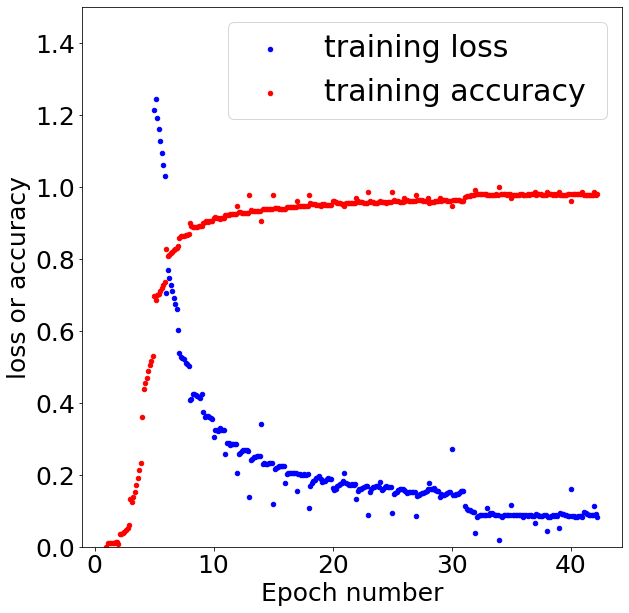

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))    
plt.subplot(111)
plt.scatter(epochlist,losslist,color='blue',s=20,label='training loss')
plt.scatter(epochlist,acculistvalue,color='red',s=20,label='training accuracy ')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0,1.5])
plt.xlabel('Epoch number',fontsize=25)
plt.ylabel('loss or accuracy',fontsize=25)
plt.legend(fontsize=30)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.4, hspace=0.2)
plt.show()

### Results
This beautiful fractal images are self-defined and self-generated random patterns. With IFS (iterated function system), we have limitedless amount of categorizoned images that can be used to identify natural images or geophysical images that have fractal nature by nature.
In this project, 100 categories of images are generated by IFS, each labelled by from 2 to 6 random number of linear vectors. Each category is then generated with 1000 instances by geometrical deformation and weighted modification to the fractor IFS vectors.
The fractal database is pretrained with a popular NN model ResNet with the category images with labels shuffled . The training accuracy approaches 98%, which means the IFS vector-defined labels can represent the fractal images.

### Reference
##### 1. Kataoka, Hirokatsu and Okayasu, Kazushige and Matsumoto, Asato and Yamagata, Eisuke and Yamada, Ryosuke and Inoue, Nakamasa and Nakamura, Akio and Satoh, Yutaka, Pre-training without Natural Images, Asian Conference on Computer Vision (ACCV), 2020. https://github.com/hirokatsukataoka16/FractalDB-Pretrained-ResNet-PyTorch
#### 2. Kaiming He, Haoqi Fan, Saining Xie, Ross Girshick, Momentum Contrast for Unsupervised Visual Representation Learning, Facebook AI Research (FAIR), 2020.
#### 3. Chun Hui, Changxiu Cheng, Lixin Ning and Jing Yang, Multifractal Characteristics of Seismogenic Systems and b Values in the Taiwan Seismic Region, International Journal of Geoinformance. 
